In this post, we are going to analyze lyrics of some of the popular artists nowadays. Music and analysis are two of my favourite things, and it was kind of obvious to combine both of them. Since I've been known to delve into analysis paralysis while making decisions, I chose to ask people on my facebook friends list about which artists they were currently listening to, instead of coming up with my own list (My propensity to listen to obscure artists doesn't help).

<img src="images/fbartists.png" alt="fb-artists" style="width: 300px;" align="middle" />

The code for this blog post is available at [this github repository](https://github.com/kvsingh/lyrics-sentiment-analysis).

This post consists of three parts - **Data Collection** (where we get the lyrics by using [**Genius's API**](https://docs.genius.com/) and a bit of **BeautifulSoup**). In the second part, **Text Analysis**, we analyze the lyrics by using metrics and generating word clouds. The third part is **Sentiment Analysis**, where we look at the sentiment (positivity and negativity) behind the lyrics of these artists, and try to draw conclusions.

Here is the list of artists I used:

* Cigarettes after Sex
* Eric Clapton
* Damien rice
* Dire Straits
* The Black keys
* Eminem
* Porcupine Tree
* Northlane
* Incubus
* Radiohead

## Data Collection

Scraping the internet for lyrics is hard work, and I really did not want to get into any hardcore data collection at this stage. 

Since I'm a bit of a beginner to the world of data scraping, I wanted a simple solution to the data collection problem. Fortunately, after a quick google search, I came accross [this really cool](https://github.com/jasonqng/genius-lyrics-search) python wrapper for getting lyrics from [Genius.com](http://genius.com/). Genius provides a handy API for searching lyrics, which is really useful when you don't have a list of songs, and do not want to parse the html heirarchy of artist, albums and songs on lyrics websites. 

In [9]:
artists = ["cigarettes after sex", "eric clapton", "damien rice", "dire straits", \
           "the black keys", "Eminem", "Porcupine tree", "Northlane", \
           "incubus", "radiohead"]

for artist in artists:
    a = search(artist, outputfilename, client_access_token)
    urls = map(lambda t: t[3], a)

'for artist in artists:\n    a = search(artist, outputfilename, client_access_token)\n    urls = map(lambda t: t[3], a)'

Esentially, what this wrapper does is provide a "search" function, where I can input an artist name, and it returns a list of urls of songs of that artist. It originally gave 100 songs, or 10 pages worth of results, but I decided to limit it to 10 songs. Genius.com has all the lyrics within a specific html tag, and I can just parse that using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/). This works for me, because at this point I really didn't want to get into the complicated syntax of html pages to parse these lyrics. If you're interested in learning more about scraping, check out BeautifulSoup and [scrapy](https://scrapy.org/) (Use BeautifulSoup if you just want to get started with simple parsing, and use scrapy if you want something like a framework with more capabilities).

In [ ]:
page = urllib2.urlopen(request)
soup = BeautifulSoup(page, "lxml")
lyrics = soup.find("div", class_= "lyrics")

Lets do some basic common-sense data cleaning for our lyrics. Looking at the lyrics, there are certain "section identifiers" like "Verse", "Chorus" which we do not need. I removed them using the following simple regular expression. I also removed the empty newlines, which may not make much difference, but it makes the lyrics a bit prettier (?) to look at.

In [ ]:
for artist in artists:
    f = open('lyrics/' + artist, 'rb')
    all_words = ''
    for sentence in f.readlines():
        this_sentence = sentence.decode('utf-8')
        all_words += this_sentence
    f.close()

    #remove identifiers like chorus, verse, etc
    all_words = re.sub(r'[\(\[].*?[\)\]]', '', all_words)
    #remove empty lines
    all_words = os.linesep.join([s for s in all_words.splitlines() if s])
    
    f = open('lyrics/' + artist + '-cleaned', 'wb')
    f.write(all_words.encode('utf-8'))
    f.close()

 The following is the starting of "Creep" by Radiohead, before the data cleaning.

>  [Verse 1]                                                                                                                                                                                                           
When you were here before                                                                                                                                                                                        
Couldn't look you in the eye                                                                                                                                                                                        
You're just like an angel                                                                                                                                                                                           
Your skin makes me cry                                                                                                                                                                                              
You float like a feather                                                                                                                                                                                            
In a beautiful world 


> [Pre-Chorus]    
> I wish I was special  
> You're so fuckin' special

> [Chorus]

> But I'm a creep  
> I'm a weirdo  
> What the hell am I doing here?  
> I don't belong here  

And this is how it looks after the cleaning:

> When you were here before  
> Couldn't look you in the eye  
> You're just like an angel  
> Your skin makes me cry  
> You float like a feather  
> In a beautiful world  
> I wish I was special  
> You're so fuckin' special  
> But I'm a creep  
> I'm a weirdo  
> What the hell am I doing here?  
> I don't belong here  


## Text Analysis and Wordclouds

Lets look at some metrics for each artist. First, we plot the number of words used by these artists in their 10 songs.

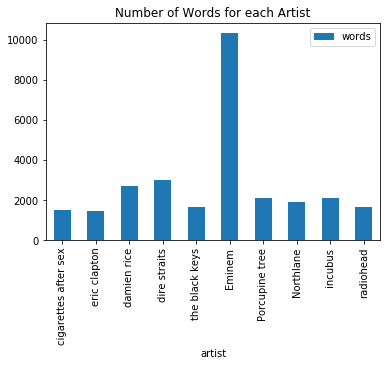

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(columns=('artist', 'words'))
i=0
for artist in artists:
    f = open('lyrics/' + artist + '-cleaned', 'rb')
    num_words = 0
    all_text = ''
    for sentence in f.readlines():
        this_sentence = sentence.decode('utf-8')
        num_words_this = len(this_sentence.split(" "))
        num_words += num_words_this

    df.loc[i] = (artist, num_words)
    i+=1

df.plot.bar(x='artist', y='words', title='Number of Words for each Artist');
plt.show()

Well, **Eminem** has the highest number of words, by far, but we shouldn't rely on this metric alone because the length of these songs are different for different artists.

A more useful metric is the **vocabulary**, or the number of unique words used by each artist. But that is still skewed by the length of a song. Dividing the number of words with the vocabulary gives us a measure of the lexical richness of each artist (i.e., what proportion of the words used in the songs are distinct?). Before measuring this metric, though, we need to do remove stop words (like 'the', 'or', 'and').

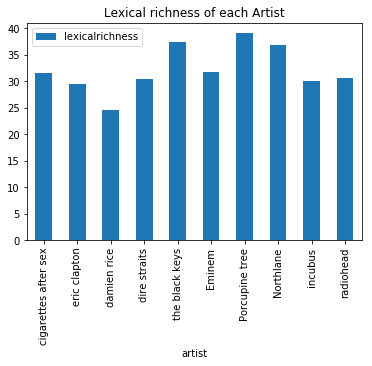

In [18]:
import string
from nltk.corpus import stopwords

df = pd.DataFrame(columns=('artist', 'lexicalrichness'))
translate_table = dict((ord(char), None) for char in string.punctuation)    #used to remove punctuation
for artist in artists:
    f = open('lyrics/' + artist + '-cleaned', 'rb')
    all_words = ''
    num_words = 0
    raw_text = ""
    for sentence in f.readlines():
        this_sentence = sentence.decode('utf-8')
        raw_text += this_sentence
            
    words = raw_text.split(" ")
    filtered_words = [word for word in words if word not in stopwords.words('english') and len(word) > 1 and word not in ['na','la']] # remove the stopwords
    
    a = len(set(filtered_words))
    b = len(words)
    df.loc[i] = (artist, (a/float(b))*100)
    i+=1
    
df.plot.bar(x='artist', y='lexicalrichness', title='Lexical richness of each Artist');
plt.show()    

It looks like Porcupine Tree, The Black Keys and Northlane use a higher variety of words in their lyrics compared to Damien Rice. Although Eminem uses a large number of words compared to the others, and his vocabulary size is also bigger, but his lexical richness is average compared to some of the other artists.
Now lets look at some of the interesting word clouds. This step doesn't have much of a purpose if you're not a fan of any of these artists, otherwise its interesting to look at the most commonly used words. I should also point out that the wordcloud library which I use, also aggregates multiple words together while considering the word frequencies, so you'll frequently see "2 word" combinations in them.

Dire straits seem to use the word "chicks" a lot.

<img src="images/dire straits.png" alt="direstraits" style="width: 400px;"/>


Eric clapton's word cloud is all about love, romance and Cocaine.

<img src="images/eric clapton.png" alt="direstraits" style="width: 400px;"/>

Northlane, a metal band, as expected, has more "negative" lyrics, dealing with isolation and loneliness and all that jazz.

<img src="images/Northlane.png" alt="direstraits" style="width: 400px;"/>

Radiohead's music seems to deal with a lot of broken hearts, truth and "mess" (I assume this has something to do with messy relationships?)

<img src="images/radiohead.png" alt="direstraits" style="width: 400px;"/>

Eminem is the only artists with visible profanities in the word cloud:

<img src="images/Eminem.png" alt="direstraits" style="width: 400px;"/>

## Sentiment Analysis

Now, we'll use sentiment analysis to describe what proportion of lyrics of these artists are positive, negative or neutral. I was initially using the [TextBlob](https://textblob.readthedocs.io/en/dev/index.html) library, which is built on top of [NLTK](http://www.nltk.org/) (also known as the Natural Language Toolkit). While searching around these NLP frameworks, I used the following simple test : whether the library is able to distinguish between the following two sentences:

> I'm feeling good

> I'm feeling so good

Ideally, the library should be able infer that the second statement is "more" positive. I tried this on both TextBlob and NLTK's Vader Sentiment analyzer. TextBlob did not give any difference, while Vader passed the test. Of course, which one is a "better" library to use is totally based on your use case, and I'm sure that TextBlob does some things much better than NLTK.

NLTK's sentiment analyzer gives a normalized unidimensional metric of sentiment of a given sentence. This value can be thresholded to determine whether the sentence is considered positive, negative, or neutral.

/usr/local/lib/python2.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


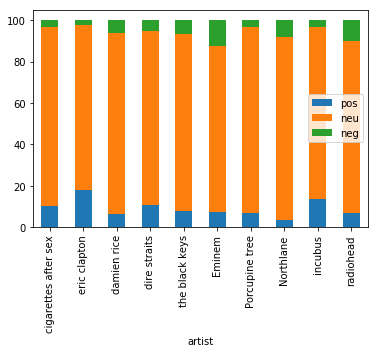

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
df = pd.DataFrame(columns=('artist', 'pos', 'neu', 'neg'))
sid = SentimentIntensityAnalyzer()
i=0
for artist in artists:
    num_positive = 0
    num_negative = 0
    num_neutral = 0

    f = open('lyrics/' + artist + '-cleaned', 'rb')
    for sentence in f.readlines():
        this_sentence = sentence.decode('utf-8')
        comp = sid.polarity_scores(this_sentence)
        comp = comp['compound']
        if comp >= 0.5:
            num_positive += 1
        elif comp > -0.5 and comp < 0.5:
            num_neutral += 1
        else:
            num_negative += 1

    num_total = num_negative + num_neutral + num_positive
    df.loc[i] = (artist, (num_positive/float(num_total))*100, (num_neutral/float(num_total))*100, (num_negative/float(num_total))*100)
    i+=1
                 
df.plot.bar(x='artist', stacked=True)
plt.show()
                

### Negative lyrics

Eminem wins the negative lyrics contest (not surprisingly), with 12.7% of his lyrics being negative. Radiohead comes in second, with 9.9%. Eric Clapton has the least negative lyrics, at 2.2 %. One surprise is - Porcupine tree, at 3.5%, considering how sad their lyrics can be. This has led me to hypothesize that aggression seems to be a much more negative emotion compared to sadness (since Eminem has much more negative lyrics than Porcupine Tree). Radiohead seems to have both a decent amount of aggression as well as sadness. Of course, all this analysis and hypothesizing is subject to the 10 songs of these artists, and any generalizations made here should be taken with a grain of salt.

### Positive lyrics

Eric Clapton wins this one at 17.8%. He also had the least percentage of negative lyrics. Conclusion : his lyrics are generally much more "happier" than the rest. Incubus comes in second at 13.4%. Northlane comes in last at 3.4% (validating the metal music stereotype). I would say, overall, Northlane and Eminem are tied at having the "least happiest" lyrics.

## That's it for now!

Of course, a lot more can be done with this topic, but a wise man once told me that one should know when to stop. I would love to know what you thought of my analysis (no doubt, you'll have strong feelings if you're fans of any of these artists). What other metrics could I have looked at? Let me know in the comments below!

In [13]:
df

,artist,pos,neu,neg
0,cigarettes after sex,10.132159,86.343612,3.524229
1,eric clapton,17.826087,80.000000,2.173913
2,damien rice,6.304348,87.608696,6.086957
3,dire straits,10.613208,84.198113,5.188679
4,the black keys,7.662835,85.440613,6.896552
5,Eminem,7.291667,80.121528,12.586806
6,Porcupine tree,6.666667,89.855072,3.478261
7,Northlane,3.384615,88.307692,8.307692
8,incubus,13.445378,83.193277,3.361345
9,radiohead,7.051282,83.012821,9.935897
